## 4. This notebook explores use of KMeans clustering to identify optimal number of clusters in the text data. 

A. Highlights: 
1. Used TFIDF feature representation as feature set
2. Applied PCA to reduce TFIDF features into 2 principal components
3. Applied elbow method and clustering metrics (davies, calinski) method to find optimal k-clusters.
4. Used PCA representation to build a scatter plot of optimal k-clusters. 
5. Explored unique words contained within each cluster. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
tqdm.pandas()
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import warnings
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')
from functools import lru_cache

#### Load Extracted Feature Set:

In [2]:
# Read Extacted Feature set
df_train = pd.read_csv('extracted_train_features_with_stopwords_pca.csv') 
df_test = pd.read_csv('extracted_test_features_with_stopwords_pca.csv')


In [3]:
# View features: 
display(df_train.head(2), df_test.head(2))

,original_text,norm_text,nlp_norm_text,lemma,pos,label,english,pca1,pca2,pca3,...,CCONJ,ADJ,NUM,X,INTJ,SYM,nsyll,sent_length,count_unk,avg_wrd_len
0,There is manuscript evidence that Austen conti...,there is manuscript evidence that austen conti...,there is manuscript evidence that austen conti...,"['there', 'be', 'manuscript', 'evidence', 'tha...","['PRON', 'AUX', 'NOUN', 'NOUN', 'SCONJ', 'PROP...",1,1,-1.241217,0.088320,-0.179642,...,3.0,1.0,0.0,0.0,0.0,0.0,58,35,6,4.485714
1,"In a remarkable comparative analysis , Mandaea...",in a remarkable comparative analysis mandaean ...,in a remarkable comparative analysis mandaean ...,"['in', 'a', 'remarkable', 'comparative', 'anal...","['ADP', 'DET', 'ADJ', 'ADJ', 'NOUN', 'PROPN', ...",1,1,-0.709833,0.029789,-0.094246,...,0.0,3.0,0.0,0.0,0.0,0.0,45,22,8,5.818182


,original_text,norm_text,nlp_norm_text,lemma,pos,id,label,english,pca1,pca2,...,ADV,NUM,INTJ,X,PUNCT,SYM,nsyll,sent_length,count_unk,avg_wrd_len
0,3-Jun-95,jun,jun,['jun'],['PROPN'],16,NaN,0,-0.390511,0.045687,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,3.0
1,14-Feb-02,feb,feb,['feb'],['PROPN'],18,NaN,0,-0.390511,0.045687,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1,3.0


#### 1. Convert text to TIFDF 

In [4]:
# Building with 2000 features

def vectorize_text(df, ngram_range= (1,2), max_features= 2000, lines = -1):
    """This function uses TFIDF vectorizer which is same as using CountVectorizer followed by TfidfTransformer. 
    It will return TFIDF representation of normed feature text, TFIDF vectorizer and normed text as output."""
    
    vectorizer  = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range, min_df=1) #avoid unknown 
    
    if lines>=0:
        norm_text = df['norm_text'].values[0:lines]
    else: 
        norm_text = df['norm_text'].values
        

    # Fit transform
    X = vectorizer.fit_transform(norm_text)

    # Convert to dataframe: 
    return X, vectorizer, norm_text
    

In [5]:
%%time
# See TFIDF representation of unigram-to-bigram model:
X, vectorizer, norm_text = vectorize_text(df_train, lines = -1, ngram_range= (1,2))

CPU times: user 13.9 s, sys: 373 ms, total: 14.3 s
Wall time: 14.6 s


In [6]:
%%time
# Build a dataframe of TFIDF features containing stopwords
df_x_tdif = pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names())
df_x_tdif.head()

CPU times: user 1.1 s, sys: 991 ms, total: 2.09 s
Wall time: 2.11 s


,able,able to,about,about the,above,academy,according,according to,acid,across,...,wwe,year,years,yellow,york,york city,you,young,your,zealand
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.181774,0.182011,0.0,0.0,...,0.0,0.151105,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 2. Reduce TFIDF dataframe in to 2 principle components: (will be used for plotting k-clusters)

In [7]:
%%time
# Convert df_x_tdif in to 2D by applying PCA: 
from sklearn.decomposition import PCA
X_pca = PCA(n_components=2).fit_transform(df_x_tdif)

CPU times: user 30.1 s, sys: 3.5 s, total: 33.6 s
Wall time: 16.2 s


In [8]:
X_pca

array([[-0.01482754, -0.13298789],
       [-0.03966647, -0.04019917],
       [ 0.0400894 , -0.12685813],
       ...,
       [-0.01254297, -0.03663783],
       [ 0.04725547, -0.08477529],
       [ 0.02397436, -0.02773463]])

#### 3. Apply K-Means to vectorized text to find optimal clusters: 

In [9]:
# Find optimal value of K: 

inertia = []
labels = []

def elbow_method():
    """This function will find optimal k_clusters where change in inertia becomes insignificant"""

    for k in tqdm(range(2, 20)): 
        km = KMeans(n_clusters=k, max_iter=50, n_init=1, init='k-means++', n_jobs=-1, random_state=0).fit(X.toarray())
        labels.append(km.labels_)
        inertia.append(km.inertia_)
    
        
    return labels, inertia


In [10]:
# Find optimal_k between 2 to 16 clusters: 
labels, inertia = elbow_method()


100%|██████████| 18/18 [11:09<00:00, 37.17s/it]


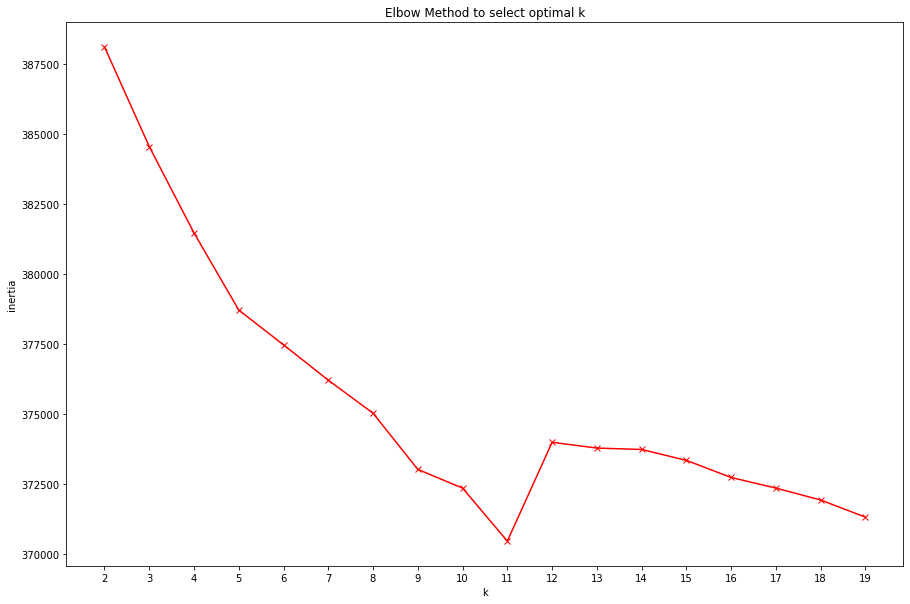

In [17]:
# Elbow Plot: 
_ = plt.figure(figsize= (15,10))
_ = plt.plot(range(2,20), inertia, 'bx-', color = 'red')
_ = plt.xticks(list(range(2,20)))
_ = plt.xlabel('k')
_ = plt.ylabel('inertia')
_ = plt.title('Elbow Method to select optimal k')

In [32]:
# Let's explore the difference in optimal K between 10 to 14. 
# Let's calculate davies and calinski score to see which one would be optimal cluster selection
# Using MininbatchKmeans
davies_score = {}
calinski_score = {}
@lru_cache(128)
def kmeans_estimator(estimator):

    for k in tqdm(range(10,14)): 
        km_optimal = estimator(n_clusters=k, max_iter=100, n_init=1, init='k-means++', random_state=0).fit(X)
        davies_score[k] =  davies_bouldin_score(X.toarray(), km_optimal.labels_)  #This should be minimum 
        calinski_score[k] = calinski_harabasz_score(X.toarray(), km_optimal.labels_) # This should be maximum
        
    return davies_score, calinski_score



In [33]:
%%time
cluster_score = kmeans_estimator(KMeans)

100%|██████████| 4/4 [01:33<00:00, 23.38s/it]

CPU times: user 2min 28s, sys: 25.1 s, total: 2min 53s
Wall time: 1min 33s


In [35]:
df_cluster_score = pd.DataFrame(cluster_score, index = ['davies','calinski'])
df_cluster_score.index.name = 'cluster_score'
df_cluster_score

,10,11,12,13
cluster_score,,,,
davies,7.221516,6.854768,5.807998,5.643510
calinski,2265.848348,2279.276977,1801.183667,1671.100138


In [40]:
%%time
# Calculate silhouette_score for comparison. 
sil_score = {}
def silhouette():
    # Calculate silhouette_score: (Optional- On a smaller sample size. This should be highest)
    for k in tqdm(range(10,14)): 
        km_optimal = KMeans(n_clusters=k, max_iter=100, n_init=1, init='k-means++', n_jobs=-1, random_state=0).fit(X)
        sil_score[k] = silhouette_score(X, km_optimal.labels_, sample_size= 100000, random_state = 0)
    return sil_score

100%|██████████| 4/4 [17:12<00:00, 258.02s/it]

CPU times: user 16min 13s, sys: 1min 58s, total: 18min 11s
Wall time: 17min 12s


In [41]:
#df_silhouette_score = pd.DataFrame(silhouette(), index = ['silhouette'])
#df_silhouette_score.index.name = 'silhouette_score'
#df_silhouette_score
print('silhouette_score at k= 12 was 0.0218, highest compared to other cluster combinations. Run time to process 100K samples was 17 min 12s')

,10,11,12,13
silhouette_score,,,,
silhouette,0.018726,0.01983,0.02128,0.021007


### Observation: 
1. We will select k = 12 as optimal clusters. It gives stable decrease in inertia beyond k at 12 as well as lower davies score and  higher calinski and silhouette scores as shown above.   

#### 4. Build scatter plot using optimal clusters

In [193]:
# Now, fit K-means using best_K:

words = {}
def fit_best_k(top_num = 100, k_best = 12):
    km_best = KMeans(n_clusters=k_best, max_iter=100, n_init=1, init='k-means++', random_state=0).fit(X)
    
    # Get cluster centers: 
    cluster_center = pd.DataFrame(km_best.cluster_centers_, columns = vectorizer.get_feature_names()).T
    
    for i in cluster_center.columns: 
    
        words[i] = cluster_center[i].sort_values(ascending = False)[:top_num].index
        
    central_words = pd.DataFrame(words)
    central_words.columns = ["cluster_"+str(i) for i in range(1, k_best+1)]
    return km_best, central_words

In [194]:
%%time
km_best, central_words = fit_best_k(top_num= 100, k_best = 12)

CPU times: user 21 s, sys: 379 ms, total: 21.4 s
Wall time: 9.02 s


In [195]:
# These are central words in each 12 clusters which also contains stopwords
central_words.head(20)

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
0,began,in the,line,won,he,have,the,be,united states,the,rrb,the
1,the,commune,the,won the,his,the,of,to,united,the best,lrb,and
2,began to,is commune,to,the,the,have been,of the,can,states,council,lrb rrb,in
3,in,in,and,in,in,been,in,to be,the united,championship,rrb is,is
4,and,france,on,championship,was,to,and,the,is city,number of,born,to
5,to,department,of,and,and,and,is,can be,the,games,lrb born,of
6,of,department in,in,award,he was,of,in the,of,city,long,is,was
7,on,commune in,railway,for,to,to have,to,and,in,through,the,by
8,with,is,station,he,of,in,was,or,in the,best,and,are
9,as,the,is,best,for,that,is the,in,is,number,of,it


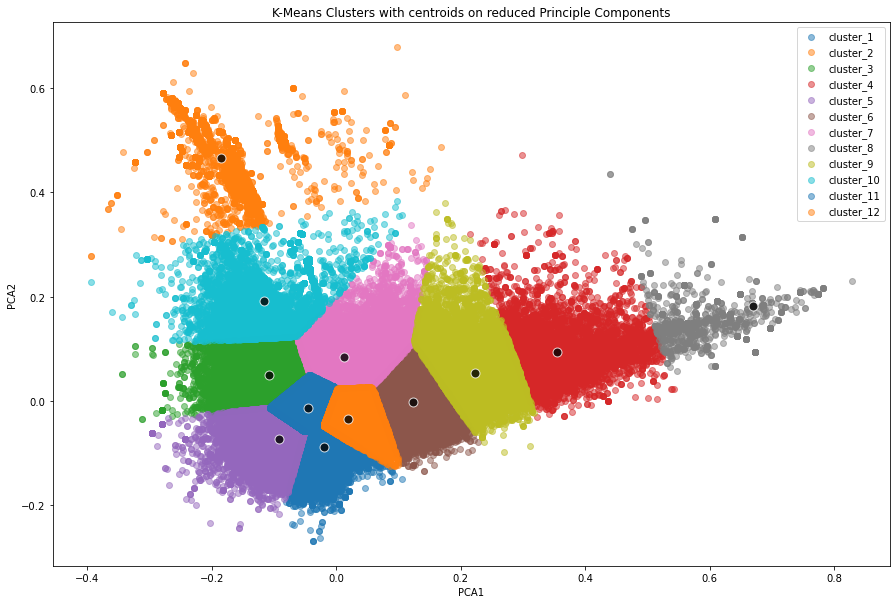

In [196]:
# Prepare to plot clusters and its centroids: 

# Get unique labels: 
label = km_best.fit_predict(X_pca)
u_labels = np.unique(label)

_ = plt.figure(figsize= (15,10))
for i in u_labels: 
    _ = plt.scatter(x = X_pca[label == i , 0] , y = X_pca[label == i , 1] , label = "cluster_"+str(i+1), cmap=plt.get_cmap('viridis'), alpha = 0.5)
    _ = plt.xlabel('PCA1')
    _ = plt.ylabel('PCA2')
    _ = plt.title('K-Means Clusters with centroids on reduced Principle Components')
    _ = plt.legend()

for i in km_best.cluster_centers_:  
    _ = plt.scatter(x = i[0],y = i[1],  s = 80, marker='o', label = "cluster_"+str(i+1), c= 'black', edgecolors='white', alpha = 0.8)



#### 5. Explore unique words within each cluster before topic modeling

### How shall we interpret these clusters? 

We will use topic modeling to explore this further. Example, identify which 12 topics seems prominent and which words does it contain.

However before that, let's see which unique words are contained within each cluster that are neither a stopwords nor an additional feature word (given to us) as a unigram. 

In [233]:
# Words within clusters without the stopwords: 
from nltk.corpus import stopwords
stopword = list(stopwords.words('english'))
additional_features = pd.read_csv('additional_features.csv')


In [252]:
def unique_cluster_words(df, col):
    
    """This function will return clustered words which are neither a single stopword nor an additional feature word"""
    
    return df[col][(~df[col].isin(stopword)) & (~df[col].isin(list(additional_features['Word'])))]

In [366]:
# Here is a section of words on display for quick reference: 
words = pd.DataFrame([np.unique(unique_cluster_words(central_words,i)) for i in central_words.columns]).T.fillna(0)
words.columns = ["cluster_"+str(i) for i in range(1, len(central_words.columns)+1)]                                          
display(words.iloc[25:30,:], words.iloc[40:45,:], words.iloc[56:60,:])

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
25,the atlantic,in eastern,0,0,that he,0,the most,used to,of the,ii,french,0
26,the first,in north,0,0,to his,0,the state,will be,oklahoma,iii,german,0
27,the th,in northern,0,0,to the,0,the th,with the,on the,illinois,in the,0
28,to be,in northwestern,0,0,was born,0,the world,would be,president of,in the,is an,0
29,to the,in picardy,0,0,was the,0,to the,0,rrb,number of,is former,0


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
40,0,loire in,0,0,0,0,0,0,the state,0,lrb,0
41,0,nord,0,0,0,0,0,0,the th,0,lrb born,0
42,0,nord pas,0,0,0,0,0,0,the united,0,lrb rrb,0
43,0,normandie,0,0,0,0,0,0,to the,0,march rrb,0
44,0,normandie in,0,0,0,0,0,0,town in,0,may rrb,0


,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12
56,0,picardy,0,0,0,0,0,0,0,0,rrb was,0
57,0,picardy in,0,0,0,0,0,0,0,0,september,0
58,0,region aquitaine,0,0,0,0,0,0,0,0,september rrb,0
59,0,region basse,0,0,0,0,0,0,0,0,spanish,0


In [367]:
from wordcloud import WordCloud, ImageColorGenerator

In [484]:
def word_cloud(df, col=None):
    cloud_text = " ".join(map(str, df[col].tolist()))
    return WordCloud(max_font_size=50, max_words=100, background_color="grey").generate(cloud_text)


cluster_1:


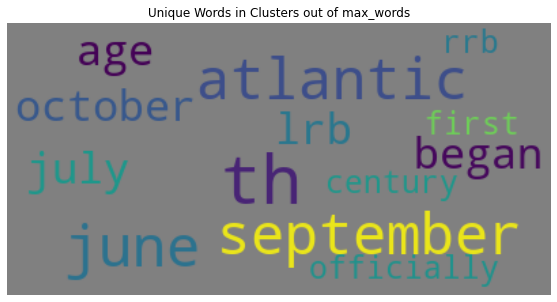

cluster_2:


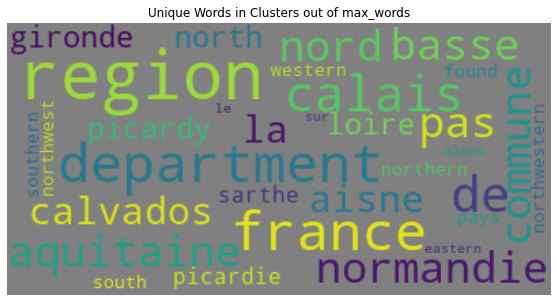

cluster_3:


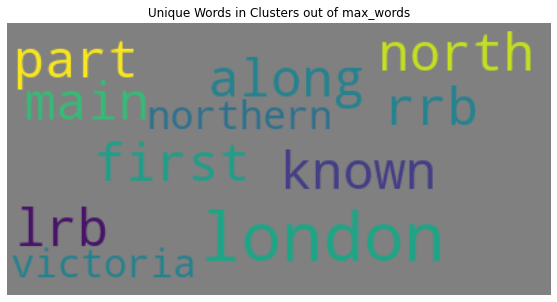

cluster_4:


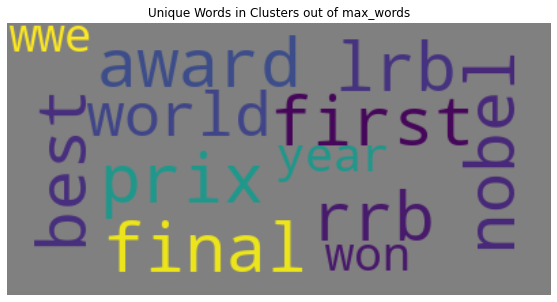

cluster_5:


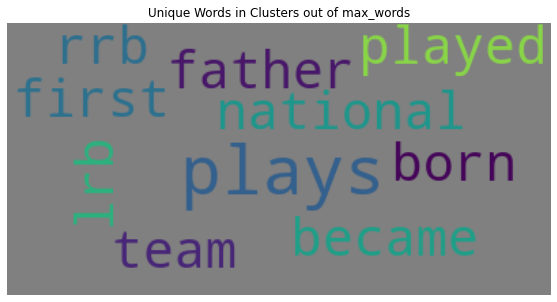

cluster_6:


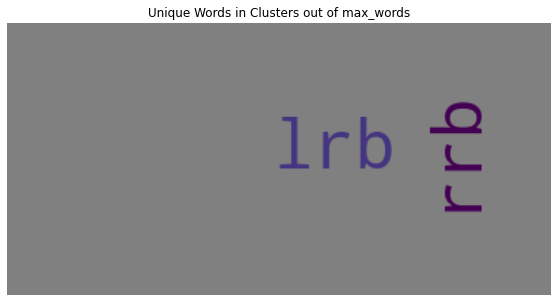

cluster_7:


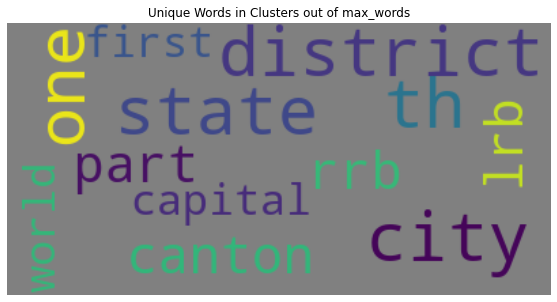

cluster_8:


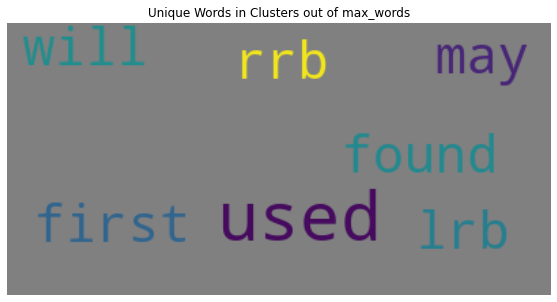

cluster_9:


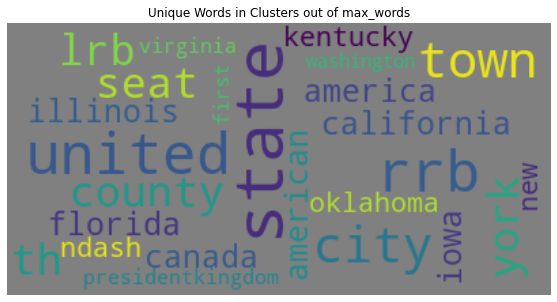

cluster_10:


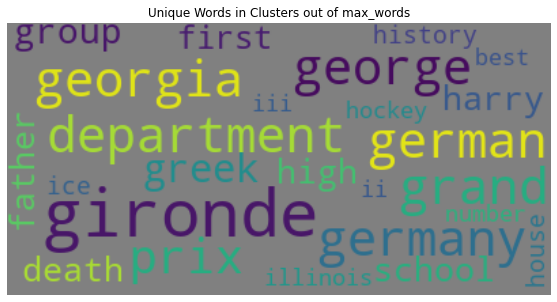

cluster_11:


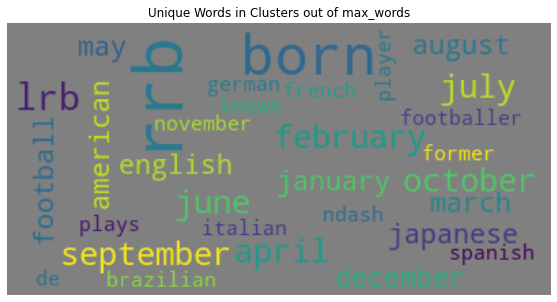

cluster_12:


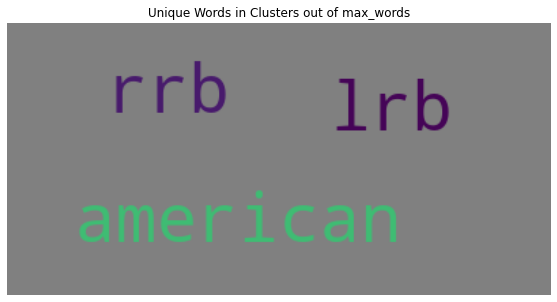

In [485]:
for i in words.columns: 
    _ = plt.figure(figsize = (10,5))
    _ =print(i+':'),plt.imshow(word_cloud(words, i), interpolation="bilinear")
    _ =plt.axis("off")
    _ = plt.title('Unique Words in Clusters out of max_words')
    _ = plt.show()

#### Observation:
1. K-Means Clustering with 12 clusters showed good quality cluster formation based on elbow method, scoring metric and PCA scatter plot shown above
2. Some of the unique words contained in the word cloud are either a bi-gram stopwords or other words which seems hard to comprehend. 
3. Unsupervised learning (K-means) was helpful in exploring some pattern in the text data but it lacks context for which we need to do topic modeling. 

4. Some of the words in seen within these clusters have combination of stopwords with other words example "the th" which further proves our assumption that stop words can add to text complexity as one of the observations seen earlier in supervised learning. 